# Explore nationalities in relation to evolution over time

In [59]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

### Create a Pandas dataframe from a SQL query

In [60]:
### Define the path to the file (a string in a variable 'db_file')
# if the data directory label is at the same level as the notebook,
# then the path is 'data/peace_import_auto.db'
db_file_address = '../data/peace_import_auto.db'

In [61]:
### Create a connection to the SQLite database of your repository
# Beware : if the database does not exist at the specified address (db_file_address)
# it will be created and will be empty. Therefore, carefully check the database address
try:
    cn = sql.connect(db_file_address)    
except Exception as e:
    # if the connection does not work
    # an error message is raised
    print(e)    


In [62]:
### This ist the query that produces the data to be analysed.
# It has to be adapted to each use case
q1 = """
WITH tw1 AS (
    SELECT nationality AS natio_code, COUNT(*) AS effectif_tot
    FROM dbp_nationalite
    GROUP BY nationality
),
tw2 AS (
    SELECT subject_uri, COUNT(*) AS eff, MIN(country) AS natio_country, MAX(birthYear) AS birthyear
    FROM dbp_nationalite
    GROUP BY subject_uri
)
SELECT tw2.birthyear, tw1.natio_code, tw1.effectif_tot
FROM tw2
JOIN dbp_nationalite dpc ON dpc.country = tw2.natio_country
JOIN tw1 ON tw1.natio_code = dpc.nationality
WHERE LENGTH(dpc.nationality) > 0
ORDER BY tw2.birthyear;
"""

In [63]:
### This instruction executes the query 
# then closes the connection to the database 
c_df= pd.read_sql_query(q1, cn)
cn.close()
# Inspect the first lines
print(c_df.head())

   birthyear natio_code  effectif_tot
0       1807   American            26
1       1807   American            26
2       1807   American            26
3       1807   American            26
4       1807   American            26


In [64]:
### Inspect maximum and minimum birth dates
print(c_df.birthyear.min(), c_df.birthyear.max())

1807 1997


In [65]:
### Exclude rows with 10 or less persons
c_df = c_df[c_df.effectif_tot > 1].sort_values(by=['natio_code','birthyear'])
print(c_df.tail())

       birthyear natio_code  effectif_tot
29107       1997      Swiss             6
29215       1997      Swiss             6
29216       1997      Swiss             6
29217       1997      Swiss             6
29218       1997      Swiss             6


In [66]:
### Count how many persons you have per country (natio_code): distribution
dc_df = c_df[['natio_code','effectif_tot']].groupby('natio_code').max()
dc_df

,effectif_tot
natio_code,
American,26
Australian,5
British,16
Canadian,8
Canadians,2
Croatian,2
Danish,2
Dutch,3
Fijian,2


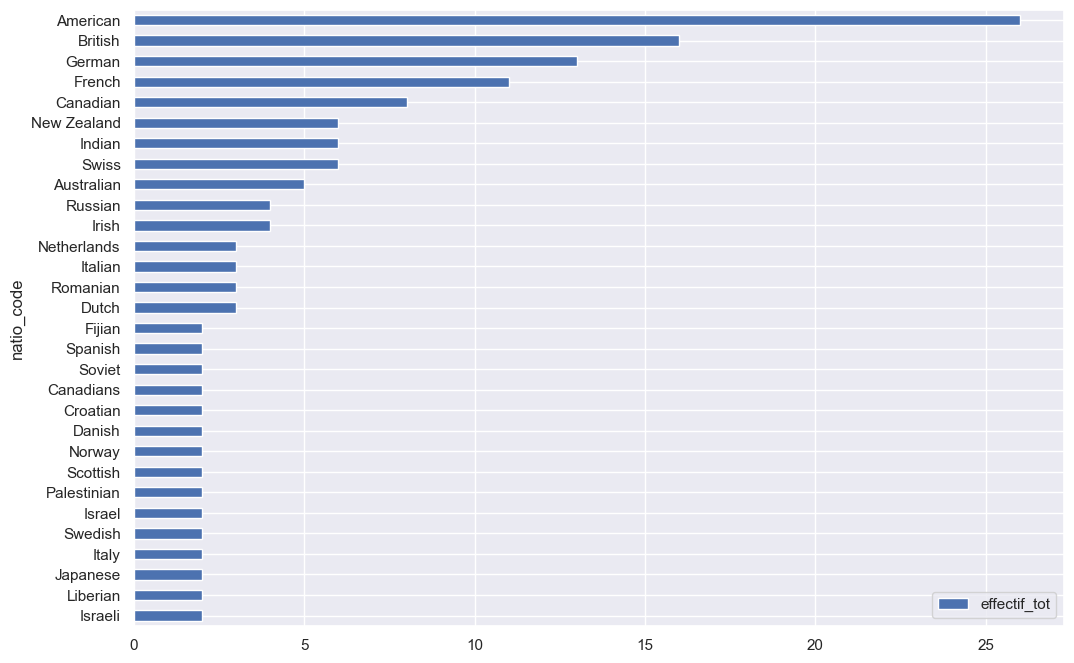

In [67]:
### Plot the distribution
dc_df.sort_values(by='effectif_tot').plot(kind='barh', figsize=(12,8))
plt.show()

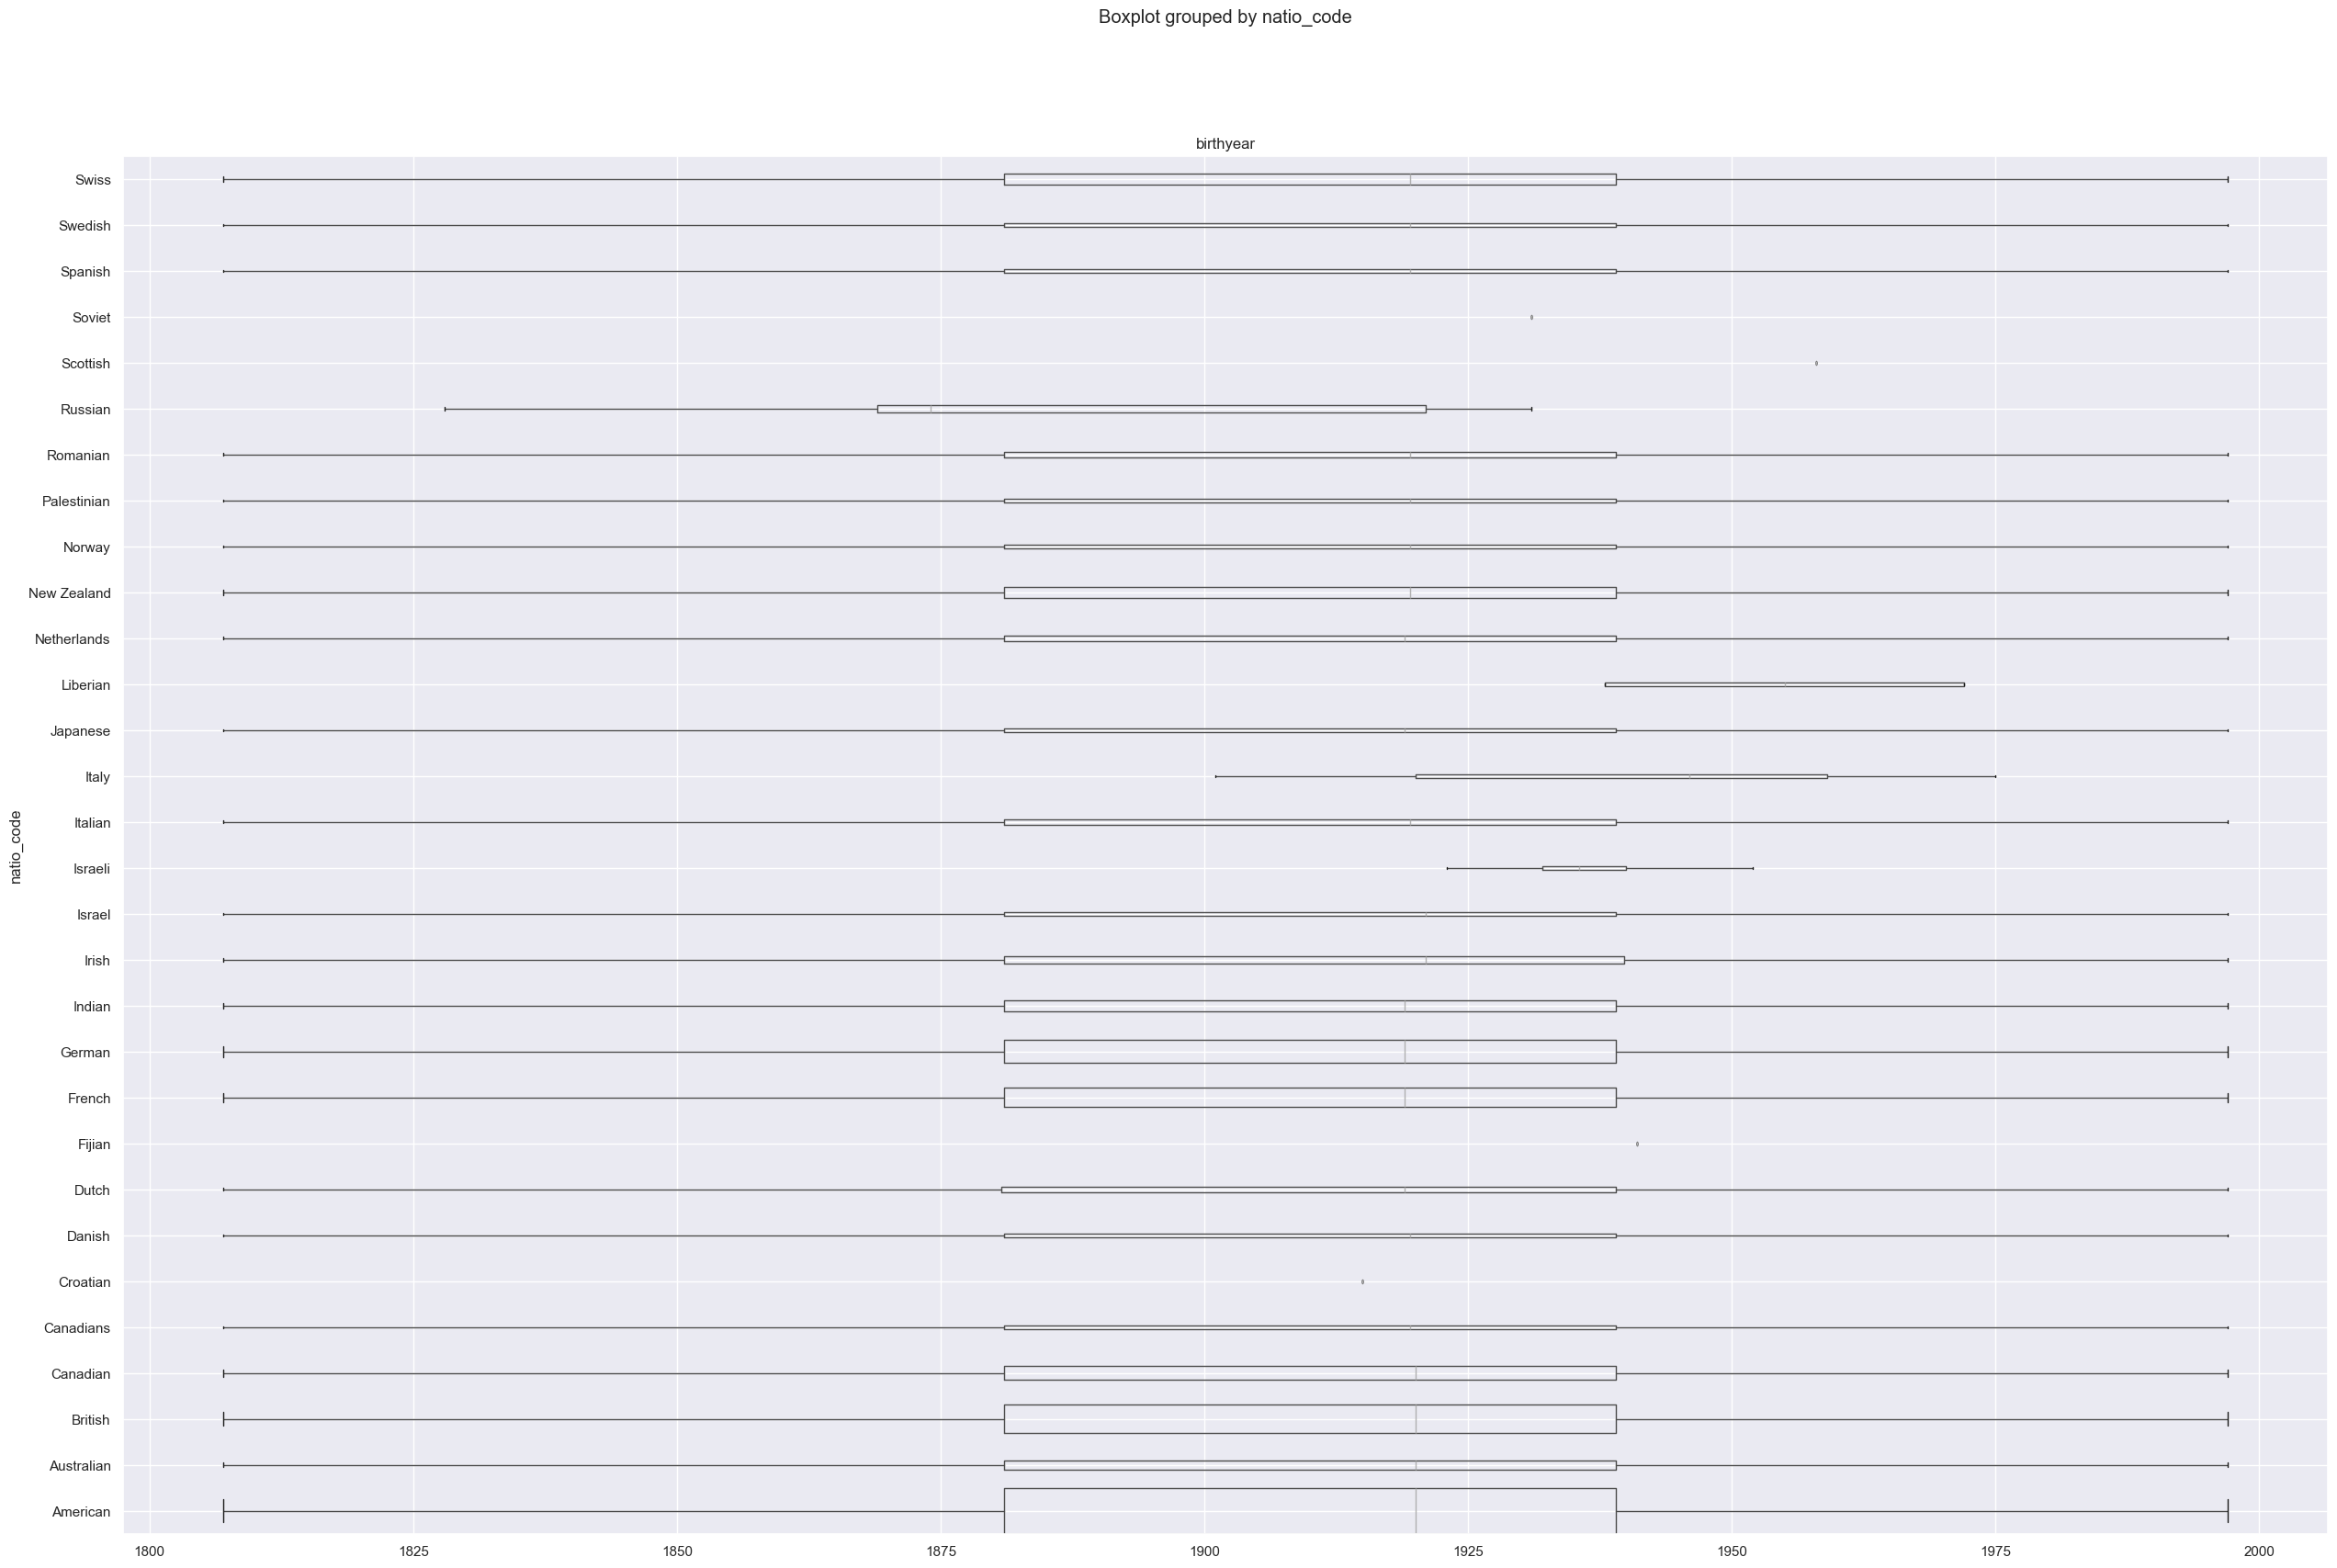

In [68]:
counts= dc_df.effectif_tot
total = float(sum(counts))
widths = [c/max(counts) for c in counts] 
c_df.sort_values(by='natio_code', ascending=True).boxplot(column='birthyear', by='natio_code',  
          vert=False, widths=widths, figsize=(30,20))
plt.show()

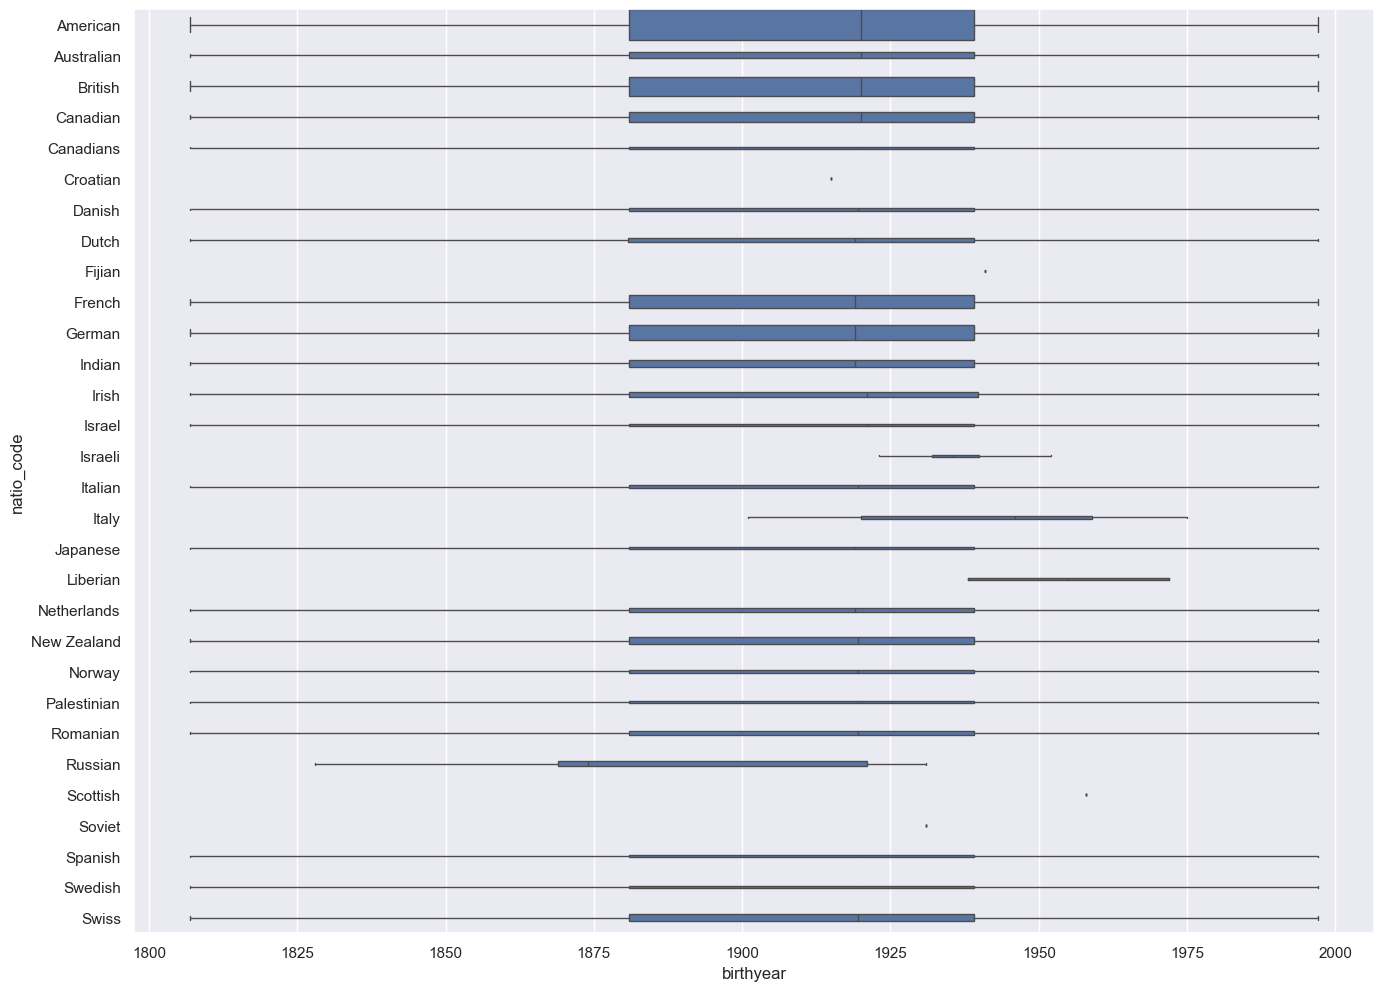

In [69]:
sns.set_theme(rc={'figure.figsize':(16,12)})

counts= dc_df.effectif_tot
total = float(sum(counts))
widths = [c/max(counts) for c in counts] 
sns.boxplot(y=c_df["natio_code"], x=c_df.birthyear, width=widths)

plt.savefig('pictures/natio_code_birth_boxplot_20241216.png')
plt.show()

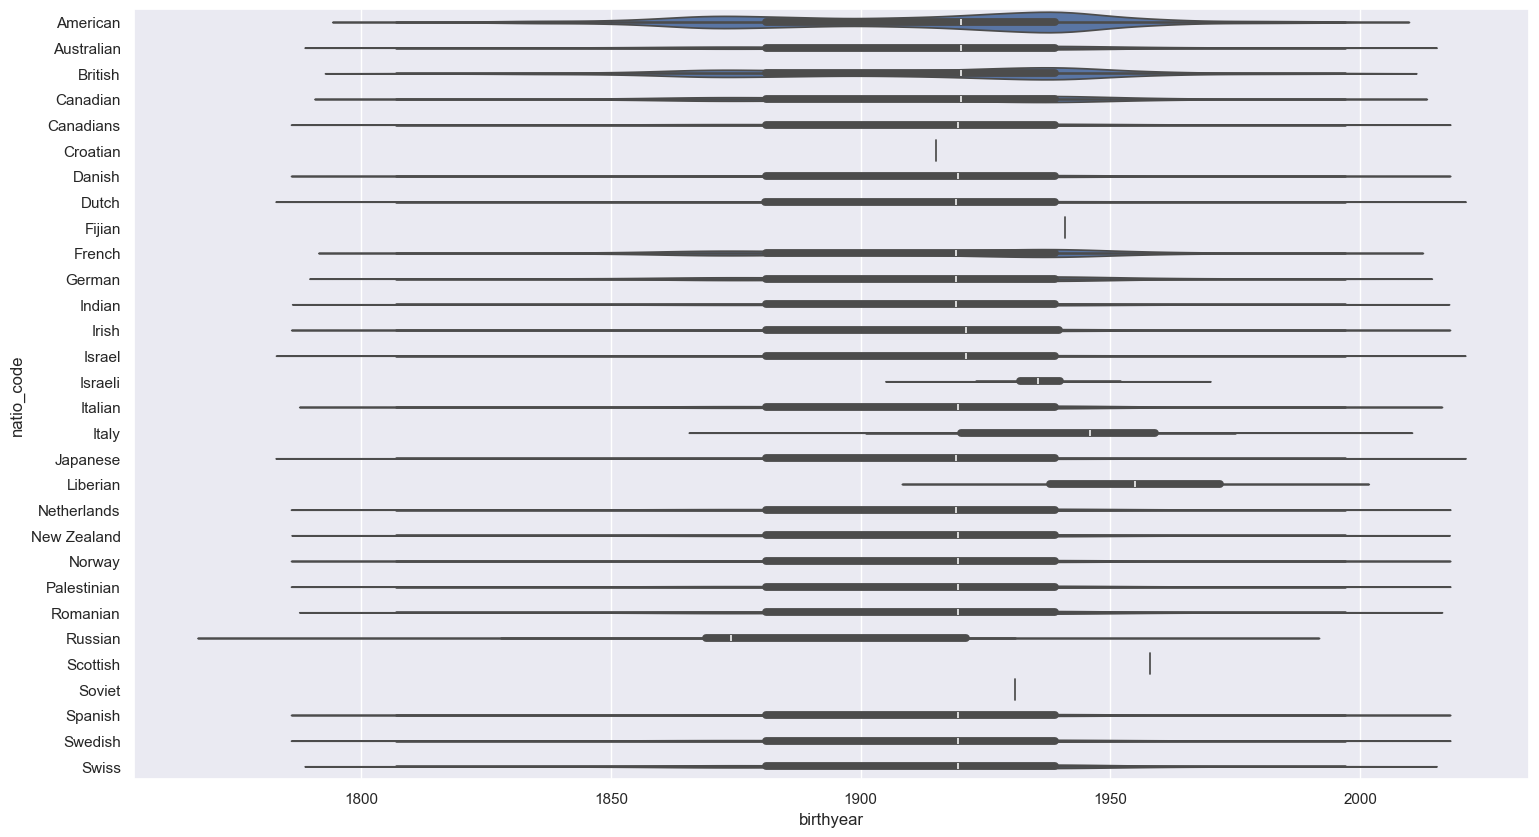

In [70]:
### Allows to inspect identity zones but not the proportion to global number
sns.set_theme(rc={'figure.figsize':(18,10)})

## noter que "density_norm" remplace "scale='count'"
sns.violinplot(y='natio_code', x='birthyear', data=c_df, 
               density_norm='count')
plt.show()

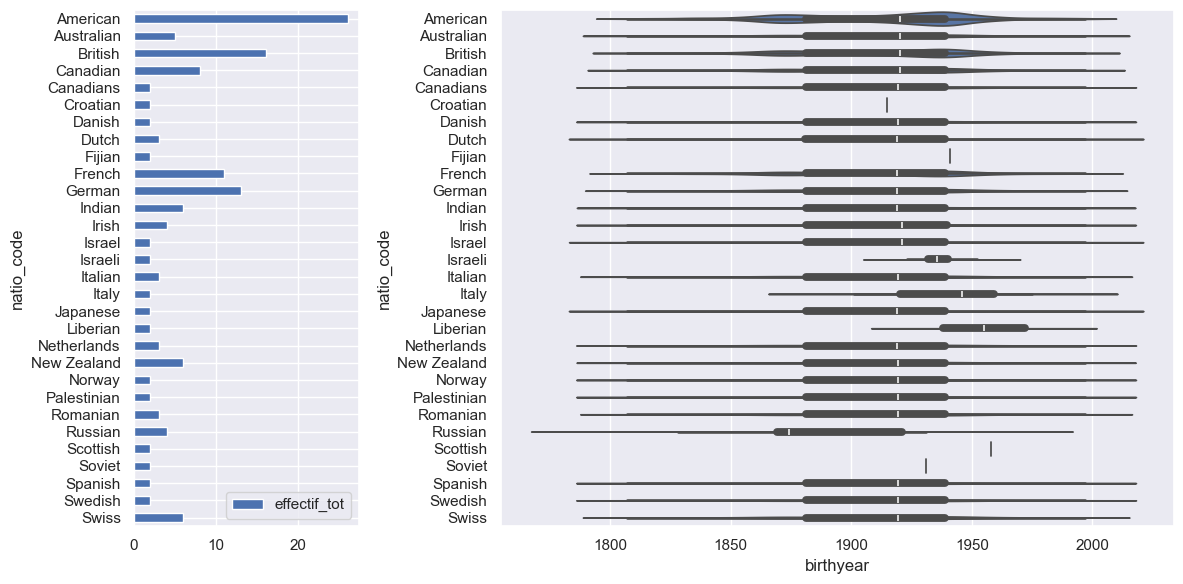

In [71]:
fig, (ax1, ax2) = plt.subplots(ncols=2, width_ratios=[1, 3])

gd_df = c_df[['natio_code','effectif_tot']].groupby(by=['natio_code']).max()\
      .sort_index(ascending=False).plot(kind='barh', figsize=(12,6), ax=ax1)

ax2 = sns.violinplot(y='natio_code', x='birthyear', data=c_df, density_norm='count')

# évite les superpositions
fig.tight_layout()

plt.savefig('pictures/natio_code_birth_year_20241209.png')
plt.show()

## Bivariate analysis of qualitative variables: time and country

In [72]:
print(min(c_df.birthyear), max(c_df.birthyear))

1807 1997


In [73]:
### Créer une liste d'années pour séparer en périodes de 10 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_10 = list(range(1841, 2002, 10))
print(l_10)

[1841, 1851, 1861, 1871, 1881, 1891, 1901, 1911, 1921, 1931, 1941, 1951, 1961, 1971, 1981, 1991, 2001]


In [74]:
## Adapt values in relation to the time
l_years = [1800, 1810, 1820, 1830, 1840, 1850, 1860, 1870, 1880, 1890, 
           1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000]


In [75]:
### fonction pd.cut
# This separation of periods isn't finegraded enough to make phenomena visible

c_df['Périodes'] = pd.cut(c_df.birthyear, l_years, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
c_df['Périodes'] = c_df['Périodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
c_df.head(3)

,birthyear,natio_code,effectif_tot,Périodes
0,1807,American,26,1800-1809
1,1807,American,26,1800-1809
2,1807,American,26,1800-1809


In [76]:
### fonction pd.qcut
# cuts the timeline in 10 periods with similar frequency of births, making them comparable

## test with 15 or 20 periods to see the difference

#c_df['Périodes'] = pd.qcut(c_df.birthyear, q=15)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
#c_df['Périodes'] = c_df['Périodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
c_df.head(3)

,birthyear,natio_code,effectif_tot,Périodes
0,1807,American,26,1800-1809
1,1807,American,26,1800-1809
2,1807,American,26,1800-1809


In [78]:
### group and count births
cdfp = c_df[['Périodes']].groupby(by='Périodes', observed=False).size()
cdfp.head()

Périodes
1800-1809     96
1810-1819    192
1820-1829     98
1830-1839    384
1840-1849    384
dtype: int64

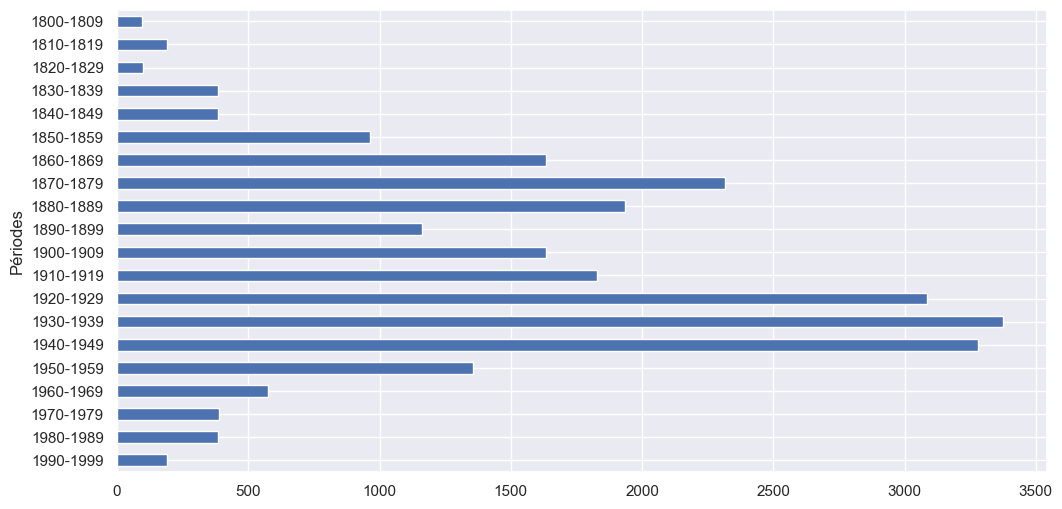

In [79]:
### group and count births
f = cdfp.sort_index(ascending=False).plot(kind='barh', figsize=(12,6))


In [80]:
## Calculate the pivot table 

X = 'Périodes'
Y = 'natio_code'

ddf = c_df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

natio_code,American,Australian,British,Canadian,Canadians,Croatian,Danish,Dutch,Fijian,French,...,Norway,Palestinian,Romanian,Russian,Scottish,Soviet,Spanish,Swedish,Swiss,Total
Périodes,,,,,,,,,,,,,,,,,,,,,
1800-1809,24,4,14,7,2,0,2,1,0,9,...,2,2,3,0,0,0,2,2,4,96
1810-1819,48,8,28,14,4,0,4,2,0,18,...,4,4,6,0,0,0,4,4,8,192
1820-1829,24,4,14,7,2,0,2,1,0,10,...,2,2,3,1,0,0,2,2,4,98
1830-1839,96,16,56,28,8,0,8,4,0,36,...,8,8,12,0,0,0,8,8,16,384
1840-1849,96,16,56,28,8,0,8,4,0,36,...,8,8,12,0,0,0,8,8,16,384
1850-1859,240,40,140,70,20,0,20,10,0,91,...,20,20,30,0,0,0,20,20,40,962
1860-1869,408,68,238,119,34,0,34,17,0,153,...,34,34,51,1,0,0,34,34,68,1635
1870-1879,577,96,336,168,48,0,48,25,0,216,...,48,48,72,1,0,0,48,48,97,2315
1880-1889,481,80,280,140,40,0,40,20,0,181,...,40,40,60,0,0,0,40,40,80,1937


In [81]:
## Total number
n = ddf.iloc[-1,-1]
print(n)

25259


In [82]:
## Pivot table without borders
D = ddf.iloc[:-1,:-1].copy(deep=True)
# D

In [83]:
### Valeurs produites par une fonction
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),1)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 246.8349248386853 , dof : 551
p-value : 1.0
phi2 = inertie (variance totale) : 0.009772157442443696
Cramer:  0.022678714159274756


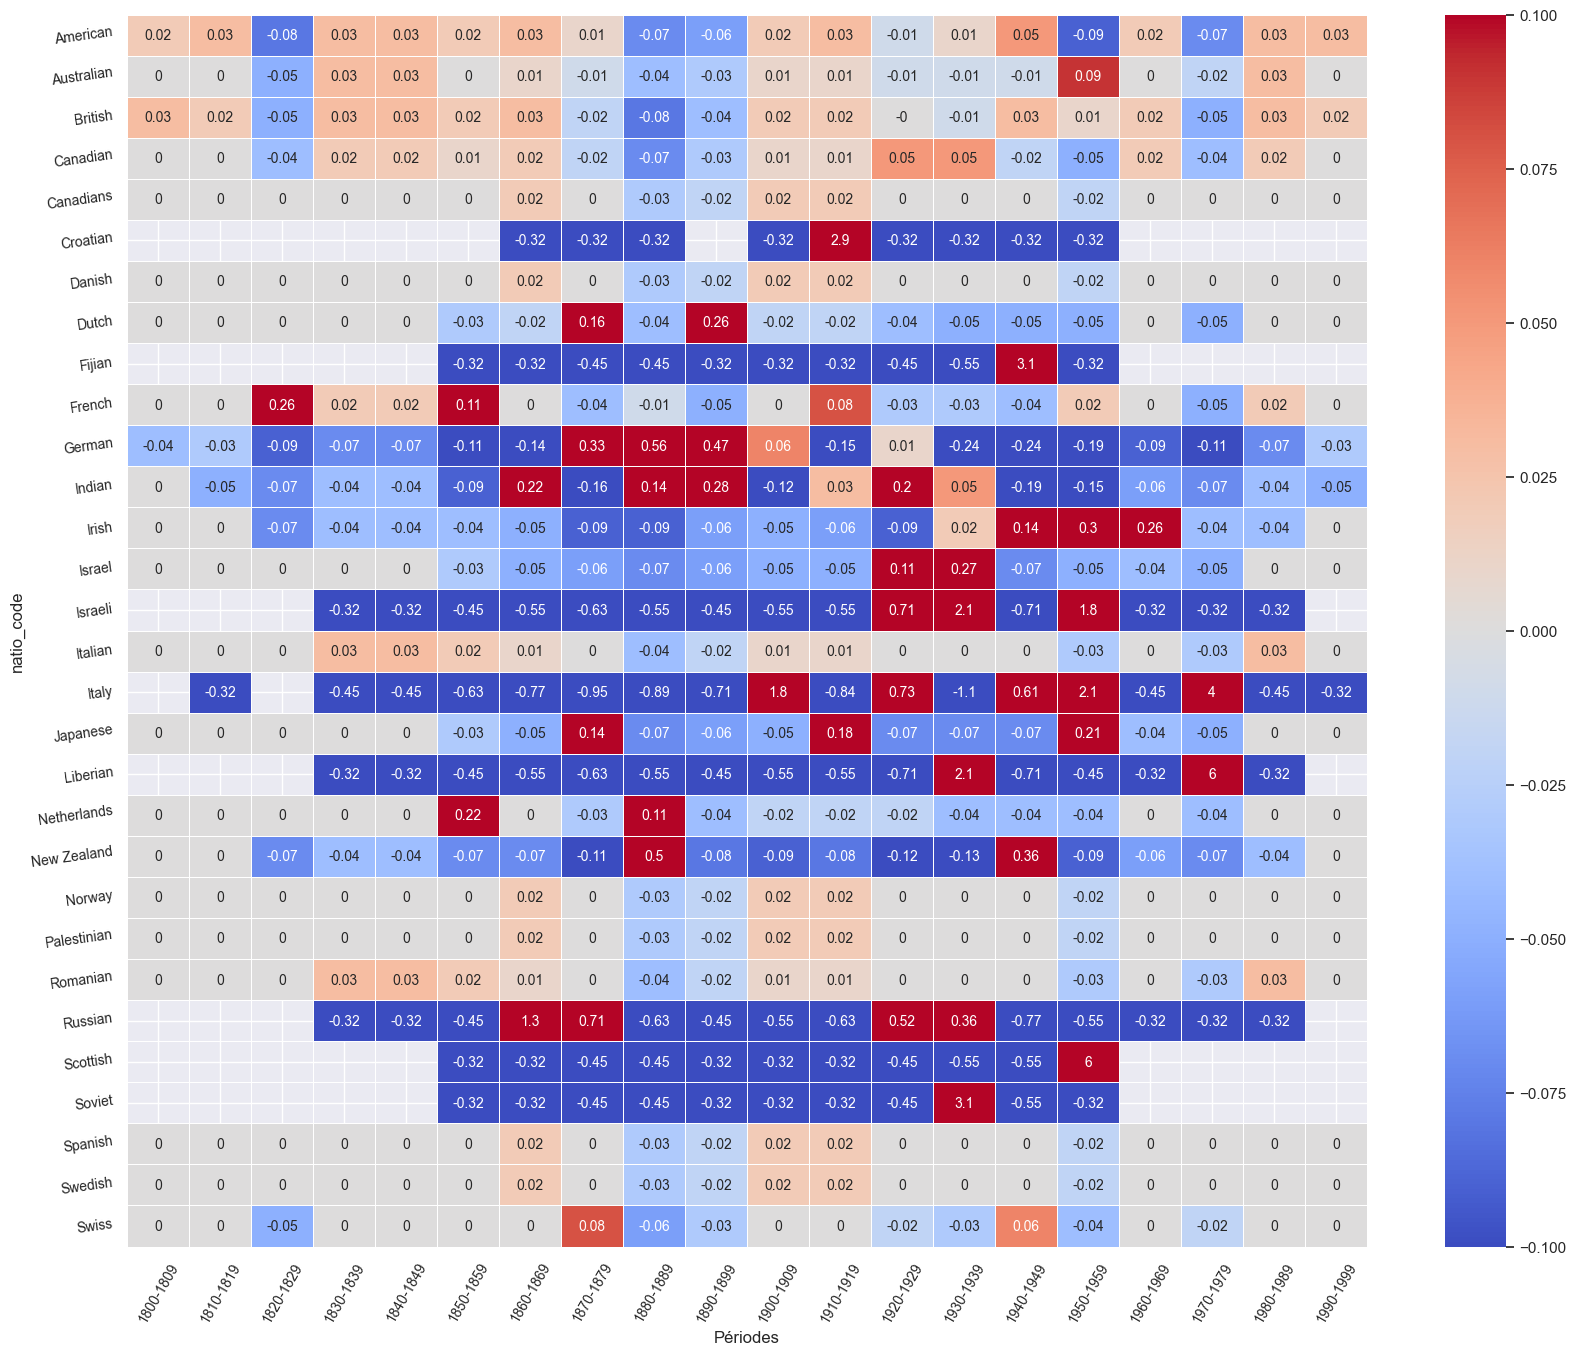

In [84]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index

residus_ponderes_T = residus_ponderes.transpose()

fig, ax = plt.subplots(figsize=(20,16))
# Sample figsize in inches
g = sns.heatmap(residus_ponderes_T, annot=residus_ponderes_T, 
                cmap="coolwarm", linewidths=.5, ax=ax,
                annot_kws={"fontsize":10})
labels = residus_ponderes_T.index
cols = residus_ponderes_T.columns
c = g.set_xticklabels(cols, rotation=60, size=10)
p = g.set_yticklabels(labels, rotation=8, size=10)

plt.savefig('pictures/natio_code_birth_period_20241216.png')

plt.show()
